In [1]:
import propagation_methods as propag
import bounds_linear_system_2d as bounds
import plot_methods as plot

### Initial state distribution: $x_0 \sim \mathcal{N}([3, 3]], \sigma I)$

In [2]:
#Initial distribution
sigma = 0.1

mean_initial_state = [3, 3]
cov_initial_state = [[sigma, 0.0],
                     [0.0, sigma]]

#Noise structure
sigma_noise = 0.05

mean_noise = [0, 0]
cov_noise = [[sigma_noise, 0.0],
             [0.0, sigma_noise]]


#Dynamics
A = [[0.5, 0.0],
     [0.0, 0.4]]


#Steps ahead for prediction
n_steps_ahead = 2

C:\Users\efigueiredomot\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\efigueiredomot\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\efigueiredomot\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\efigueiredomot\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated a

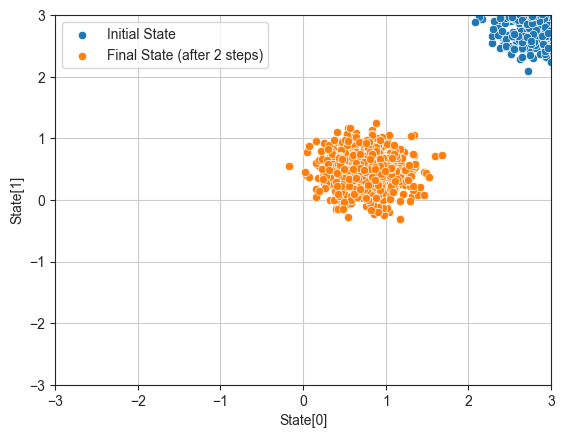

In [3]:
n_simulations = 1000
initial_states, final_states = propag.monteCarloSimulationSystem(n_simulations, A, mean_initial_state, cov_initial_state, mean_noise, cov_noise, n_steps_ahead)
plot.plotSystemPropagation(initial_states, final_states, n_steps_ahead)

In [4]:
regions = propag.createRegions([1, 5], [1, 5], 10)
signatures = propag.placeSignatures(regions, 0.5)

C:\Users\efigueiredomot\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\efigueiredomot\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


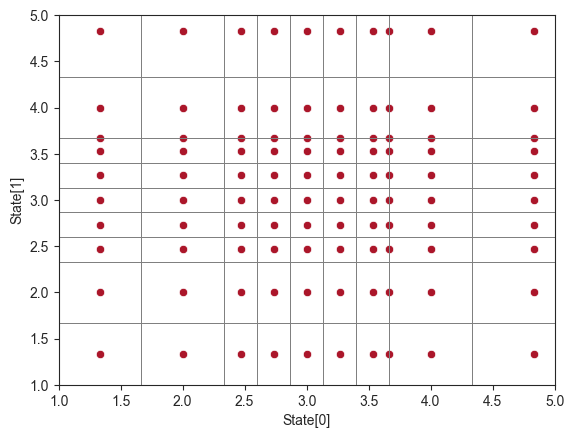

In [5]:
plot.plot_signatures(signatures, regions, [1, 5])

50
0.023868767832561023
32
0.03693039068857549


C:\Users\efigueiredomot\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\efigueiredomot\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


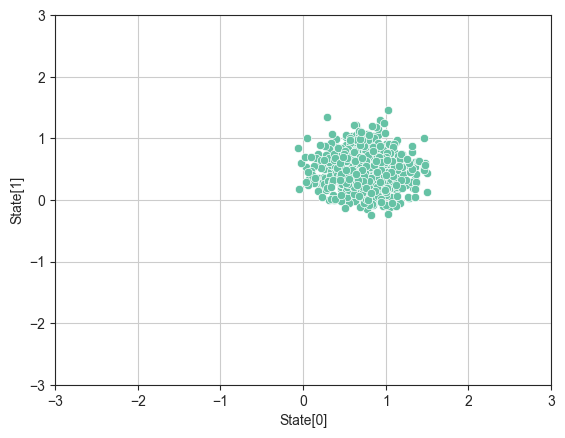

In [6]:
n_steps = range(n_steps_ahead-1) #There is a minus one because the sampleFromGmm already propagates the signatures for sampling, see equations

n_signatures = 50
print(n_signatures)

gmm = ([1.0], [mean_initial_state], cov_initial_state)

regions = propag.createRegions([mean_initial_state[0] - 4*cov_initial_state[0][0]**0.5, mean_initial_state[0] + 4*cov_initial_state[0][0]**0.5], [mean_initial_state[1] - 4*cov_initial_state[1][1]**0.5, mean_initial_state[1] + 4*cov_initial_state[1][1]**0.5], n_signatures)
signatures = propag.placeSignatures(regions, 0.5)
probas = propag.computeSignatureProbabilities(regions, [mean_initial_state], cov_initial_state, [1.0])

tv_bound = bounds.computeTV_withMax(A, signatures, regions, gmm, cov_noise)

print(tv_bound)

for step in n_steps:

    gmm = (probas, propag.propagateSignatures(A, signatures), cov_noise)

    probas, signatures, regions = propag.propagateUncertaintyOneStep(A, regions, signatures, probas, cov_noise)

    tv_bound = bounds.computeTV_withMax(A, signatures, regions, gmm, cov_noise)

    print(tv_bound)



samples = propag.sampleFromGMM(A, 1000, probas, signatures, cov_noise)

plot.plotSamplesFromGMM(samples)

In [7]:
# n_steps = range(n_steps_ahead-1) #There is a minus one because the sampleFromGmm already propagates the signatures for sampling, see equations

# regions = propag.createRegions([1, 5], [1, 5], 150)
# signatures = propag.placeSignatures(regions, 0.5)
# probas = propag.computeSignatureProbabilities(regions, [mean_initial_state], cov_initial_state, [1.0])

# #Bound for TV1
# #gmm = (probas, propag.propagateSignatures(A, signatures), cov_noise)   #THERE IS SOMETHING WRONG
# gmm = ([1.0], [mean_initial_state], cov_initial_state)
# tv_bound = bounds.computeTVbound(A, signatures, regions, cov_noise, gmm)

# print(tv_bound)

# for step in n_steps:
#     probas, signatures, regions = propag.propagateUncertaintyOneStep(A, regions, signatures, probas, cov_noise)



# samples = propag.sampleFromGMM(A, 1000, probas, signatures, cov_noise)

# plot.plotSamplesFromGMM(samples)

In [8]:
print(tv_bound)

0.03693039068857549


C:\Users\efigueiredomot\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\efigueiredomot\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


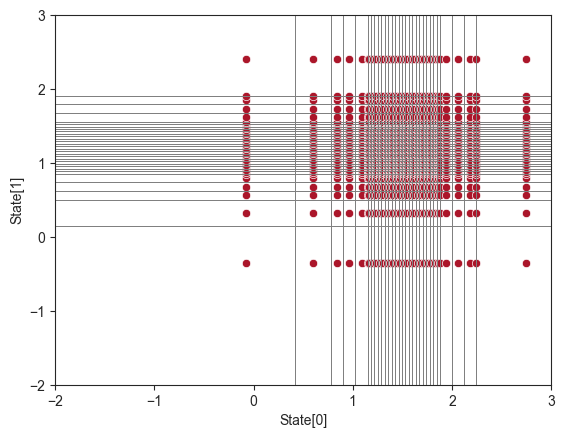

In [9]:
plot.plot_signatures(signatures, regions, [-2, 3])